# Data Science - Laboratorio 7
## Minería de Texto: Análisis de redes sociales

---
### Integrantes:
- Diego Alberto Leiva 21752
- José Pablo Orellana 21970
- - -

## Librerias

In [1]:
# Operaciones con datos
import pandas as pd

# Visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Visualización de redes
import networkx as nx
from pyvis.network import Network
import webbrowser

# Procesamiento de lenguaje natural
import re
import spacy
import nltk
from nltk.corpus import stopwords

# Utilidades
from collections import Counter
import random

## Conjuntos de datos

Se recopilaron aproximadamente 5,000 tweets de la cuenta @traficogt y @BArevalodeLeon hasta el 12 de septiembre de 2024. Estos datos vienen en formato JSON con metadatos que incluyen el ID de usuario, texto del tweet, menciones, retweets, y número de favoritos, etc. Estos tweets reflejan las interacciones de los usuarios de la ciudad con relación a la situación del tráfico, o del presidente electo de Guatemala.

### Selección

Para este análisis, se ha seleccionado el conjunto de datos proveniente exclusivamente de la cuenta @traficogt, con el objetivo de abordar preguntas clave como: 
- **¿Cómo ha impactado la temporada de lluvias en el tráfico de la ciudad?** 
- **¿Cuáles son las áreas más afectadas por la congestión vehicular?**
- **¿En qué horarios se presentan los mayores atascos según los usuarios de la plataforma X (anteriormente Twitter)?**

El tráfico es uno de los problemas más persistentes y visibles en la vida diaria de los habitantes de la ciudad. La congestión vehicular, exacerbada durante la temporada de lluvias, afecta tanto la movilidad como la calidad de vida de millones de personas. Este análisis permitirá no solo entender cómo las lluvias han complicado aún más el tráfico en la ciudad, sino también identificar patrones recurrentes en las zonas y horarios de mayor congestión. Esto podría ofrecer información útil para las autoridades y ciudadanos que buscan mitigar el impacto de estos problemas.

## Carga de Dataset

In [2]:
traficogt_df = pd.read_json('data/traficogt.txt', lines=True, encoding='utf-8')

## Comprensión Inicial

### Información General del Dataset

In [3]:
def get_DF_info(df):
    """
    Función que genera un dataframe con información sobre las columnas de un dataframe dado.

    Args:
        df (pandas.DataFrame): El dataframe de entrada.
        
    Returns:
        None
    """
    # Crear un dataframe con la información de las columnas
    info = pd.DataFrame({
        'Nombre Columna': df.columns,
        'Tipo de Dato': df.dtypes,
        'Valores Nulos (%)': (df.isnull().sum() * 100 / df.shape[0]).round(2),
        # Si la columna contiene dict o list, mostrar el tipo. Si no, calcular los valores únicos
        'Valores Únicos': df.apply(lambda x: 'dict' if x.apply(lambda y: isinstance(y, dict)).any() else 
                                             ('list' if x.apply(lambda y: isinstance(y, list)).any() else x.nunique()))
    }).reset_index(drop=True)

    # Mostrar la información del DataFrame
    print(f"\nEl DataFrame tiene {df.shape[0]} filas (registros) y {df.shape[1]} columnas (variables)\n")
    display(info)

In [4]:
# Mostrar información del DataFrame de 'traficogt'
print("Información del dataset: traficogt.txt")
get_DF_info(traficogt_df)

Información del dataset: traficogt.txt

El DataFrame tiene 5605 filas (registros) y 32 columnas (variables)



,Nombre Columna,Tipo de Dato,Valores Nulos (%),Valores Únicos
0,id,int64,0.00,5597
1,id_str,int64,0.00,5597
2,url,object,0.00,5597
3,date,"datetime64[ns, UTC]",0.00,5588
4,user,object,0.00,dict
5,lang,object,0.00,24
6,rawContent,object,0.00,5589
7,replyCount,int64,0.00,196
8,retweetCount,int64,0.00,350
9,likeCount,int64,0.00,502


El análisis inicial ha revelado la presencia de estructuras complejas como diccionarios y listas en varias columnas del conjunto de datos. Esto indica que algunos campos contienen datos anidados, los cuales requieren un procesamiento especial para ser adecuadamente analizados. Además, se ha observado una discrepancia en los tipos de datos; por ejemplo, variables que deberían ser tratadas como cadenas de texto (str) se están manejando como enteros (int).

### Visualizar Dataframe

In [5]:
pd.set_option('display.max_columns', None)
traficogt_df.head()

,id,id_str,url,date,user,lang,rawContent,replyCount,retweetCount,likeCount,quoteCount,bookmarkedCount,conversationId,conversationIdStr,hashtags,cashtags,mentionedUsers,links,viewCount,retweetedTweet,quotedTweet,place,coordinates,inReplyToTweetId,inReplyToTweetIdStr,inReplyToUser,source,sourceUrl,sourceLabel,media,card,_type
0,1834236045598056867,1834236045598056960,https://x.com/traficogt/status/183423604559805...,2024-09-12 14:22:06+00:00,"{'id': 93938886, 'id_str': '93938886', 'url': ...",es,Es comprensible la resolución... El ruso sabe ...,0,0,1,0,0,1834236045598056867,1834236045598056960,[],[],[],[],393.0,NaN,"{'id': 1834029142565658846, 'id_str': '1834029...",None,NaN,NaN,NaN,None,"<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android,Twitter for Android,"{'photos': [], 'videos': [], 'animated': []}",None,snscrape.modules.twitter.Tweet
1,1834029142565658846,1834029142565658880,https://x.com/monymmorales/status/183402914256...,2024-09-12 00:39:56+00:00,"{'id': 976875408, 'id_str': '976875408', 'url'...",es,La corrupción de la @CC_Guatemala\nes descarad...,0,56,84,4,1,1834029142565658846,1834029142565658880,[],[],"[{'id': 783345301256073216, 'id_str': '7833453...",[{'url': 'https://www.prensalibre.com/guatemal...,1587.0,NaN,None,None,NaN,NaN,NaN,None,"<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android,Twitter for Android,"{'photos': [], 'videos': [], 'animated': []}",{'title': 'La Corte de Constitucionalidad orde...,snscrape.modules.twitter.Tweet
2,1834039491826180424,1834039491826180352,https://x.com/animaldgalaccia/status/183403949...,2024-09-12 01:21:04+00:00,"{'id': 1730828822029750272, 'id_str': '1730828...",qme,@PNCdeGuatemala @mingobguate @FJimenezmingob @...,0,0,1,0,0,1834039491826180424,1834039491826180352,[],[],"[{'id': 130315077, 'id_str': '130315077', 'use...",[],91.0,NaN,None,None,NaN,NaN,NaN,"{'id': 130315077, 'id_str': '130315077', 'user...","<a href=""http://twitter.com/download/iphone"" r...",http://twitter.com/download/iphone,Twitter for iPhone,"{'photos': [], 'videos': [], 'animated': []}",None,snscrape.modules.twitter.Tweet
3,1833963729136091179,1833963729136091136,https://x.com/EstacionDobleA/status/1833963729...,2024-09-11 20:20:01+00:00,"{'id': 1802661334355456000, 'id_str': '1802661...",qam,@amilcarmontejo @AztecaNoticiaGT @BancadaSemil...,0,0,0,0,0,1833963727575781534,1833963727575781632,[],[],"[{'id': 372126670, 'id_str': '372126670', 'use...",[],46.0,NaN,None,None,NaN,1.833964e+18,1.833964e+18,"{'id': 1802661334355456000, 'id_str': '1802661...","<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android,Twitter for Android,"{'photos': [], 'videos': [], 'animated': []}",None,snscrape.modules.twitter.Tweet
4,1833665391698092330,1833665391698092288,https://x.com/CubReserva/status/18336653916980...,2024-09-11 00:34:31+00:00,"{'id': 1155617398675988481, 'id_str': '1155617...",es,@soy_502 @AztecaNoticiaGT @CONAPgt @DenunciaEM...,0,0,1,0,0,1833664431084949711,1833664431084949760,[],[],"[{'id': 1687984068, 'id_str': '1687984068', 'u...",[],171.0,NaN,None,None,NaN,1.833664e+18,1.833664e+18,"{'id': 1155617398675988481, 'id_str': '1155617...","<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android,Twitter for Android,"{'photos': [], 'videos': [], 'animated': []}",None,snscrape.modules.twitter.Tweet


Esta visualización del conjunto de datos muestra que efectivamente hay variables que tienen diccionarios con data anidada, por lo que sera necesario extraer solo la informacion relevante de estas variables para evitar agregar una mayor dimensionalidad al dataframe con variables que no aportan información relevante.

### Identificación de Variables

**Descripción de las variables del dataset `traficogt.txt`**

- `id`: Identificador numérico único del tweet.
- `id_str`: Identificador del tweet en formato string, que representa el mismo valor que `id`.
- `url`: URL del tweet en la plataforma `X` (anteriormente conocida como Twitter).
- `date`: Fecha y hora en que el tweet fue publicado.
- `user`: Información del usuario que publicó el tweet (un diccionario que incluye detalles como el nombre de usuario, seguidores, y más).
- `lang`: Idioma en el que está escrito el tweet.
- `rawContent`: Texto completo del tweet.
- `replyCount`: Número de respuestas al tweet.
- `retweetCount`: Número de retweets que ha recibido el tweet.
- `likeCount`: Número de "likes" que ha recibido el tweet.
- `quoteCount`: Número de veces que el tweet ha sido citado.
- `bookmarkedCount`: Número de veces que el tweet ha sido guardado en marcadores.
- `conversationId`: Identificador del hilo de conversación al que pertenece el tweet.
- `conversationIdStr`: Identificador en formato string del hilo de conversación al que pertenece el tweet.
- `hashtags`: Lista de hashtags incluidos en el tweet.
- `cashtags`: Lista de cashtags (etiquetas relacionadas con símbolos de acciones o monedas) en el tweet.
- `mentionedUsers`: Lista de usuarios mencionados en el tweet.
- `links`: Lista de enlaces incluidos en el tweet.
- `viewCount`: Número de visualizaciones del tweet.
- `retweetedTweet`: Información sobre el tweet retuiteado (puede estar vacío si el tweet no es un retweet).
- `quotedTweet`: Información del tweet citado (si el tweet cita a otro).
- `place`: Información geográfica del lugar desde donde se publicó el tweet (si está disponible).
- `coordinates`: Coordenadas geográficas (si están disponibles) del lugar donde se publicó el tweet.
- `inReplyToTweetId`: Identificador del tweet al que se respondió (si aplica).
- `inReplyToTweetIdStr`: Identificador en formato string del tweet al que se respondió.
- `inReplyToUser`: Información del usuario al que se le respondió (si aplica).
- `source`: Texto que describe la plataforma desde la cual se publicó el tweet (ej., "Twitter for iPhone").
- `sourceUrl`: URL de la plataforma desde la cual se publicó el tweet.
- `sourceLabel`: Etiqueta descriptiva de la plataforma desde la cual se publicó el tweet.
- `media`: Información multimedia asociada al tweet, como fotos o videos.
- `card`: Información relacionada con tarjetas de Twitter (por ejemplo, tarjetas de resumen de enlaces).
- `_type`: Tipo de entidad, que en este caso indica que es un tweet (valor fijo).

### Observaciones Importantes de Variables

**Variables Duplicadas**

Aunque es útil tener tanto el identificador numérico (`id`, `conversationId`, `inReplyToTweetId`) como el string (`id_str`, `conversationIdStr`,`inReplyToTweetIdStr`), es probable que una sola de estas columnas sea suficiente. Dado que son representaciones del mismo dato, se considerará eliminar una de ellas dependiendo de cuál se adapte mejor a los análisis posteriores.


**Variables Irrelevantes**

Dada la naturaleza cruda del conjunto de datos hay varias variables que realmente no aportan información
relevante en relación al objetivo de este análisis. Por lo tanto se considerará eliminar directamente columnas como `_type`, `source`, `media`, `coordinate`, etc. ya que su información va mas relacionada al Tweet como tal, y no al contenido y contexto del mismo.

**Idioma**

Hay una variable `lang` referente al idioma en el que se redacto el tweet, por lo que se considera la opción de conservar unicamente los tweets en español para que la data sea consistente, con la posibilidad de incluir los que esten en inglés si no fueran suficientes.

## Preprocesamiento y Limpieza

### Valores Nulos

In [6]:
def plot_null_values(df, name):
    """
    Función que genera un gráfico de barras con los valores nulos de un dataframe dado.

    Args:
        df (pandas.DataFrame): El dataframe de entrada.
        
    Returns:
        None
    """
    plt.figure(figsize=(12, 6))
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
    plt.title(f'Valores Nulos en archivo {name}')
    plt.show()

#### Visualización de valores nulos

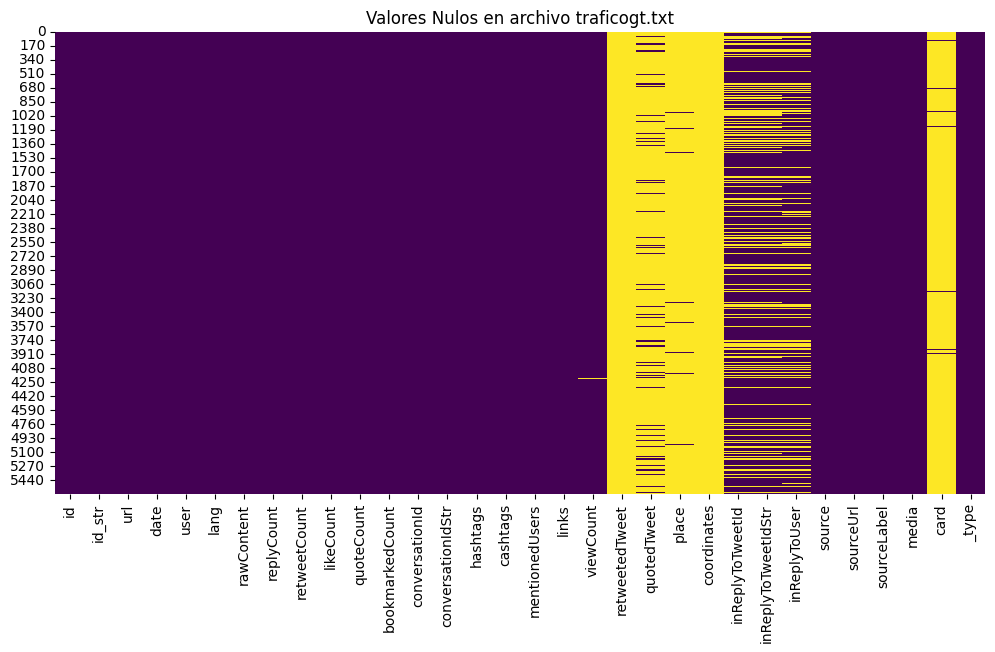

In [7]:
plot_null_values(traficogt_df, 'traficogt.txt')

#### Observaciones de nulos

**Variables con muchos nulos**

`retweetedTweet`, `quotedTweet`, `coordinates`, `place`, `media`, y `card` tienen una gran cantidad de valores nulos (**cercana al 100%**), lo que hace que su retención en el análisis sea poco práctica. Dado que el enfoque de este estudio es entender cómo la temporada de lluvias afecta el tráfico en la ciudad, estas variables no ofrecen información relevante.
- `Retweets` no contienen contenido original y no reflejan nuevas observaciones sobre el tráfico.
- `quotedTweet` contiene toda la información del tweet al que se menciona, sin embargo esta variable no aporta de manera directa como interactuan los usuarios.
- Datos geográficos (`coordinates`, `place`) tienen un bajo porcentaje de datos completos, lo que impide realizar análisis espaciales útiles sobre las zonas más congestionadas de la ciudad.
- Contenido multimedia y tarjetas (`media`, `card`) no aportan información directa que ayude a analizar el tráfico en la ciudad.

**Variables con algunos nulos**

Las columnas como `inReplyToTweetId`, `inReplyToUser` y contienen información importante sobre la interacción entre usuarios, por lo que no se eliminarán. Sin embargo, los valores nulos se reemplazarán por una etiqueta que indique que el tweet no aplica a estas categorías, permitiendo el análisis de respuestas y citas de manera más precisa.

#### Manejo de Nulos

Como se menciono anteriormente hay variables con casi todos sus datos faltantes y que no aportan infomración relevante en el análisis por lo que serán eliminadas:
- `retweetedTweet`
- `coordinates`
- `place`
- `media`
- `card`

In [8]:
# Eliminar las columnas con muchos nulos que no aportan al análisis
columns_to_drop = ['retweetedTweet', 'coordinates', 'place', 'media', 'card', 'quotedTweet', 'sourceUrl', 'sourceLabel']
traficogt_df = traficogt_df.drop(columns=columns_to_drop)

In [9]:
# Reemplazar los valores nulos en las columnas seleccionadas con un string representativo
columns_with_nans = ['inReplyToTweetId', 'inReplyToUser', 'inReplyToTweetIdStr']
traficogt_df[columns_with_nans] = traficogt_df[columns_with_nans].fillna('no aplica')
# Convertir los valores numéricos en 'inReplyToTweetId' a enteros, manteniendo "No aplica"
traficogt_df['inReplyToTweetId'] = traficogt_df['inReplyToTweetId'].apply(lambda x: int(x) if isinstance(x, float) else x)

# Eliminar las filas con valores nulos en las columnas restantes
traficogt_df = traficogt_df.dropna()

In [10]:
# Contar los valores nulos en cada columna del DataFrame
null_counts = traficogt_df.isnull().sum()
print(null_counts)

id                     0
id_str                 0
url                    0
date                   0
user                   0
lang                   0
rawContent             0
replyCount             0
retweetCount           0
likeCount              0
quoteCount             0
bookmarkedCount        0
conversationId         0
conversationIdStr      0
hashtags               0
cashtags               0
mentionedUsers         0
links                  0
viewCount              0
inReplyToTweetId       0
inReplyToTweetIdStr    0
inReplyToUser          0
source                 0
_type                  0
dtype: int64


### Datos Anidados (Variables diccionario o lista)

Dado que hay variables dentro del conjunto de datos que poseen estructuras como diccionarios o listas (listas de diccionarios) dentro de sus valores, es necesario manejarlos para poder obtener información relevante. La estrategia sera evaluar el contenido de los diccionarios y determinar que keys son relevantes en este analisis para conservarlas en variables separadas, para las listas se evaluara el contenido y se creara un string con los valores concatenados separados por comas, si fuese el caso de listas de diccionarios, en ellos tambien se hara la evaluacion de keys para conservar solo la mas importante y con ello crear el string concatenado.

#### Identificación de datos anidados

In [11]:
def identify_columns_with_dicts_or_lists(df):
    dict_columns = []
    list_columns = []
    
    for col in df.columns:
        if df[col].apply(lambda x: isinstance(x, dict)).any():
            dict_columns.append(col)
        elif df[col].apply(lambda x: isinstance(x, list)).any():
            list_columns.append(col)
    
    print(f"Columnas con diccionarios:")
    for col in dict_columns:
        print(f"  - {col}")
    print(f"\nColumnas con listas:")
    for col in list_columns:
        print(f"  - {col}")

    return dict_columns, list_columns

In [12]:
dict_columns, list_columns = identify_columns_with_dicts_or_lists(traficogt_df)

Columnas con diccionarios:
  - user
  - inReplyToUser

Columnas con listas:
  - hashtags
  - cashtags
  - mentionedUsers
  - links


#### Análisis de contenidos

Hay 2 columnas que poseen diccionarios, y 4 con listas, a continuación se analizara el contenido de cada una de estas variables

In [13]:
# Mostrar las primeras filas de las columnas con diccionarios
traficogt_df[dict_columns].head()

,user,inReplyToUser
0,"{'id': 93938886, 'id_str': '93938886', 'url': ...",no aplica
1,"{'id': 976875408, 'id_str': '976875408', 'url'...",no aplica
2,"{'id': 1730828822029750272, 'id_str': '1730828...","{'id': 130315077, 'id_str': '130315077', 'user..."
3,"{'id': 1802661334355456000, 'id_str': '1802661...","{'id': 1802661334355456000, 'id_str': '1802661..."
4,"{'id': 1155617398675988481, 'id_str': '1155617...","{'id': 1155617398675988481, 'id_str': '1155617..."


In [14]:
# Buscar la primera instancia no vacía de diccionario en la columna 'user'
non_empty_user = traficogt_df[traficogt_df['user'].apply(lambda x: isinstance(x, dict) and len(x) > 0)]['user']
if non_empty_user.shape[0] > 0:
    print("Contenido del primer diccionario en la columna 'user':")
    display(non_empty_user.iloc[0])
else:
    print("No se encontraron diccionarios NO VACIOS en la columna 'user'")

Contenido del primer diccionario en la columna 'user':


{'id': 93938886,
 'id_str': '93938886',
 'url': 'https://x.com/traficogt',
 'username': 'traficogt',
 'displayname': 'traficoGT',
 'rawDescription': 'Noticias de ciudad de Guatemala',
 'created': '2009-12-01 20:42:19+00:00',
 'followersCount': 314368,
 'friendsCount': 137,
 'statusesCount': 52385,
 'favouritesCount': 3471,
 'listedCount': 291,
 'mediaCount': 1292,
 'location': 'Guatemala',
 'profileImageUrl': 'https://pbs.twimg.com/profile_images/1782036597841530880/-tVuhOdK_normal.jpg',
 'profileBannerUrl': None,
 'protected': None,
 'verified': False,
 'blue': False,
 'blueType': None,
 'descriptionLinks': [],
 'pinnedIds': [],
 '_type': 'snscrape.modules.twitter.User'}

Dado que el análisis se centra en el impacto del tráfico en la ciudad y las interacciones entre usuarios, no todos los atributos del diccionario `user` son relevantes.

El diccionario presenta una gran cantidad de datos relacionados al usuario de X que realizó el tweet.
Por lo tanto, es importante destacar que realmente de todos estos atributos el único que es relevante mantener es el `username`, pues el resto son datos que no aportan mucho valor para el análisis de tweets o de relaciones.

In [15]:
# Mostrar todo el contenido de un registro de la variable 'inReplyToUser'
non_empty_reply = traficogt_df[traficogt_df['inReplyToUser'].apply(lambda x: isinstance(x, dict) and len(x) > 0)]['inReplyToUser']

if non_empty_reply.shape[0] > 0:
    print("Contenido de un registro de la variable 'inReplyToUser':")
    display(non_empty_reply.iloc[0])
else:
    print("No se encontraron diccionarios NO VACIOS en la columna 'inReplyToUser'")

Contenido de un registro de la variable 'inReplyToUser':


{'id': 130315077,
 'id_str': '130315077',
 'username': 'PNCdeGuatemala',
 'displayname': 'PNC de Guatemala',
 '_type': 'snscrape.modules.twitter.UserRef'}

Similar a la variable `user`, este diccionario muestra parte de los datos del usuario, por lo que el único dato relevante a mantener es  `username`.

In [16]:
# Mostrar las primeras filas de las columnas con listas
traficogt_df[list_columns].head()

,hashtags,cashtags,mentionedUsers,links
0,[],[],[],[]
1,[],[],"[{'id': 783345301256073216, 'id_str': '7833453...",[{'url': 'https://www.prensalibre.com/guatemal...
2,[],[],"[{'id': 130315077, 'id_str': '130315077', 'use...",[]
3,[],[],"[{'id': 372126670, 'id_str': '372126670', 'use...",[]
4,[],[],"[{'id': 1687984068, 'id_str': '1687984068', 'u...",[]


In [17]:
# Mostrar todo el contenido de un registro de la variable 'hashtags'
non_empty_hashtags = traficogt_df[traficogt_df['hashtags'].apply(lambda x: isinstance(x, list) and len(x) > 0)]['hashtags']

if non_empty_hashtags.shape[0] > 0:
    print("Contenido de un registro de la variable 'hashtags':")
    display(non_empty_hashtags.iloc[0])
else:
    print("No se encontraron listas NO VACIAS en la columna 'hashtags'")

Contenido de un registro de la variable 'hashtags':


['urgente', 'Desaparecido']

Esta lista puede ser de ayuda al evaluar el contenido de los tweets, ya que los hashtags se pueden perder al momento de limpiar el texto de los mismos, el contenido es una lista de strings que representan el hashtag por lo que simplemente se pueden concatenar en un único string y separarlos por comas.

In [18]:
# Mostrar todo el contenido de un registro de la variable 'cashtags'
non_empty_cashtags = traficogt_df[traficogt_df['cashtags'].apply(lambda x: isinstance(x, list) and len(x) > 0)]['cashtags']
if non_empty_cashtags.shape[0] > 0:
    print("Contenido de un registro de la variable 'cashtags':")
    display(non_empty_cashtags.iloc[0])
else:
    print("No se encontraron listas NO VACIAS en la columna 'cashtags'")

No se encontraron listas NO VACIAS en la columna 'cashtags'


Esta variable se eliminará ya que no hay ningun registro con una lista con contenido, por lo tanto no es relevante.

In [19]:
# Mostrar todo el contenido de un registro de la variable 'mentionedUsers'
non_empty_mentionedUsers = traficogt_df[traficogt_df['mentionedUsers'].apply(lambda x: isinstance(x, list) and len(x) > 0)]['mentionedUsers']
if non_empty_mentionedUsers.shape[0] > 0:
    print("Contenido de un registro de la variable 'mentionedUsers':")
    display(non_empty_mentionedUsers.iloc[0])
else:
    print("No se encontraron listas NO VACIAS en la columna 'mentionedUsers'")

Contenido de un registro de la variable 'mentionedUsers':


[{'id': 783345301256073216,
  'id_str': '783345301256073216',
  'username': 'CC_Guatemala',
  'displayname': 'CC Guatemala',
  '_type': 'snscrape.modules.twitter.UserRef'}]

Esta variable es un tanto compleja pues muestra que es una lista de diccionarios de usuarios, cada diccionario presenta una estructura similar a `inReplyToUser`.
Por lo tanto en este caso conservar solo el username de cada diccionario sera la mejor opcion para terminar con un único string con los nombres concatenados separados por comas.

In [20]:
# Mostrar todo el contenido de un registro de la variable 'links'
non_empty_links = traficogt_df[traficogt_df['links'].apply(lambda x: isinstance(x, list) and len(x) > 0)]['links']
if non_empty_links.shape[0] > 0:
    print("Contenido de un registro de la variable 'links':")
    display(non_empty_links.iloc[0])
else:
    print("No se encontraron listas NO VACIAS en la columna 'links'")

Contenido de un registro de la variable 'links':


[{'url': 'https://www.prensalibre.com/guatemala/justicia/la-corte-de-constitucionalidad-ordena-al-renap-que-le-extienda-dpi-a-la-familia-rusa-bitkov-condenados-por-uso-de-documentos-falsos-breaking/',
  'text': 'prensalibre.com/guatemala/just…',
  'tcourl': 'https://t.co/0J24ZCXJ2c'}]

Esta es otra variable que no aporta información relevante, pues contiene una lista de diccionarios, donde cada diccionario contiene datos relacionados a los enlaces colocados dentro del tweet.

#### Manejo de dato anidados

Los hallazgos de la sección anterior mostraron que de las variables relacionadas a usuarios vale la pena conservar unicamente el `username`.

Por otro lado las variables `links` y `cashtags` no tienen datos relevantes para este estudio por lo que serán eliminadas.

Asimismo `hashtags` pasara a ser un único string con los valores de cada hashtag concatenado separado por comas siguiendo este formato **"hashtag1, hashtag2, ..., hashtagN"**

Finalmente `mentionedUsers` pasara de ser una lista de diccionarios a un único
string con los valores del username de cada user separado por comas siguiendo un formato similar al de `hashtags`: **"username1, username2, ..., usernameN"**

Para ambas transformaciones de listas, en caso sean vacios, se utilizará el string **"no aplica"**.

In [21]:
def extract_username(value):
    """
    Función que extrae el nombre de usuario de un diccionario.

    Args:
        value (dict): El diccionario de entrada.

    Returns:
        str: El nombre de usuario extraído del diccionario. 
                Si no se encuentra, retorna 'No aplica'.
    """
    if isinstance(value, dict):
        return value.get('username', 'no aplica')
    
    return 'no aplica'

In [22]:
def process_list_column(value):
    """
    Función que procesa una lista de diccionarios y extrae el nombre de usuario de cada uno.

    Args:
        value (list): La lista de diccionarios de entrada.

    Returns:
        str: El nombre de usuario extraído de cada diccionario, separados por comas. 
                Si no se encuentra, retorna 'No aplica'.
    """
    if isinstance(value, list):
        # Si la lista está vacía, retornar 'No aplica'
        if len(value) == 0:
            return 'no aplica'
        
        # Si la lista contiene strings, concatenarlos
        if all(isinstance(i, str) for i in value):
            return ', '.join(value)
        
        # Si la lista contiene diccionarios, extraer el username
        elif all(isinstance(i, dict) for i in value):
            return ', '.join([i.get('username', 'No aplica') for i in value])
        
    return 'no aplica'

In [23]:
# Aplicar la función extract_username a las columnas con diccionarios
traficogt_df['user_username'] = traficogt_df['user'].apply(extract_username)
traficogt_df['inReplyToUser_username'] = traficogt_df['inReplyToUser'].apply(extract_username)

In [24]:
# Aplicar la función process_list_column a las columnas con listas
traficogt_df['hashtags_str'] = traficogt_df['hashtags'].apply(process_list_column)
traficogt_df['mentionedUsers_str'] = traficogt_df['mentionedUsers'].apply(process_list_column)

In [25]:
# Limpiar las columnas con diccionarios y listas originales 
# Eliminar las columnas originales 
traficogt_df = traficogt_df.drop(columns=dict_columns + list_columns)

# Renombrar las columnas procesadas para que tengan el mismo nombre que las originales
traficogt_df = traficogt_df.rename(columns={
    'user_username': 'user',
    'inReplyToUser_username': 'inReplyToUser',
    'hashtags_str': 'hashtags',
    'mentionedUsers_str': 'mentionedUsers'
})

# Mostrar las primeras filas del DataFrame procesado
traficogt_df[['user', 'inReplyToUser', 'hashtags', 'mentionedUsers']].head()

,user,inReplyToUser,hashtags,mentionedUsers
0,traficogt,no aplica,no aplica,no aplica
1,monymmorales,no aplica,no aplica,CC_Guatemala
2,animaldgalaccia,PNCdeGuatemala,no aplica,"PNCdeGuatemala, mingobguate, FJimenezmingob, d..."
3,EstacionDobleA,EstacionDobleA,no aplica,"amilcarmontejo, AztecaNoticiaGT, BancadaSemill..."
4,CubReserva,CubReserva,no aplica,"soy_502, AztecaNoticiaGT, CONAPgt, DenunciaEMP..."


Ahora las variables con datos anidados pasaron a ser strings mas faciles de procesar.

### Idiomas de Tweets

Anteriormente se encontró que la variable `lang`, que indica el idioma en el que está escrito el tweet, contiene al menos **24 valores únicos**. Esto sugiere que varios tweets no están escritos en español, lo que podría afectar la coherencia del análisis si el contenido en otros idiomas no es relevante o comprensible. Con el fin de garantizar la consistencia del análisis y evitar posibles sesgos, se evaluaran los diferentes idiomas presentes y el contenido de los tweets correspondientes. Este análisis permitirá decidir si es conveniente eliminar los tweets en otros idiomas o, en su defecto, conservar aquellos que puedan aportar información valiosa, como los escritos en inglés.

#### Identificación de Idiomas

In [26]:
# Obtener los valores únicos de la columna 'lang' y el conteo de filas por valor
lang_counts = traficogt_df['lang'].value_counts()
display(lang_counts)

lang
es     5066
qme     340
en       51
qam      40
pt       32
und      24
it        7
ca        6
in        5
tl        4
eu        3
qht       3
fr        2
lt        2
ht        2
et        2
lv        2
cs        2
art       2
da        2
de        1
tr        1
nl        1
qst       1
Name: count, dtype: int64

Los Idiomas únicos encontrados en la columna `lang` son:
- es (español)
- und (indefinido)
- en (inglés)
- da (danés)
- ca (catalán)
- cs (checo)
- it (italiano)
- lv (letón)
- de (alemán)
- et (estonio)
- pt (portugués)
- tl (tagalo)
- in (indonesio)
- ht (haitiano)
- lt (lituano)
- tr (turco)
- eu (euskera)
- fr (francés)
- nl (neerlandés)
- art (emojis)

**Idiomas sin definicion clara**
- qst
- qme
- qam
- qht
Puede ser que estos sean tipos que Twitter definiera, como un tipo de dato personalizado.

Es evidente que la mayoria de estos idiomas tienen pocos tweets relacionados, con excepcion de qme con 340.

#### Análsis de contenidos

In [27]:
# Obtener el primer tweet para cada idioma
first_tweets_by_lang = traficogt_df.groupby('lang')[['lang','rawContent']].apply(lambda x: x.iloc[0]).reset_index(drop=True)

# Mostrar los primeros tweets de cada idioma
pd.set_option('display.max_colwidth', None)
display(first_tweets_by_lang)
pd.reset_option('display.max_colwidth')

,lang,rawContent
0,art,🤡
1,ca,@traficogt @BArevalodeLeon LA JAZMIN DE LA VERG@ NO HA DE PODER DORMIR🫵🤡🫵🤡🫵🤡😊👍
2,cs,@traficogt Netcetero............M
3,da,@Tito8829 @PrensaComunitar @traficogt Vuele ALV netcenter
4,de,@traficogt Fraaaaaude
5,en,@lahoragt @traficogt “Posibles”
6,es,Es comprensible la resolución... El ruso sabe de engrasar maquinaria.
7,et,@traficogt Ja ja ja ja ja ja Tremendo Idota https://t.co/29JB8nf7jY
8,eu,@traficogt @AlvaroArzuE basura
9,fr,@hshetemul @traficogt La Chancha


La variable `lang`, que indica el idioma en el que está escrito cada tweet, inicialmente mostró al menos **24 valores únicos**, lo que sugirió la presencia de tweets en varios idiomas. Sin embargo, tras un análisis detallado de los tweets, se descubrió que muchos de ellos, aunque clasificados como otros idiomas, realmente están escritos en español o contienen elementos de jerga, menciones a otros usuarios, hashtags y emojis, lo que dificulta una correcta clasificación por parte del algoritmo de detección de idiomas de X.

Dado que la mayoría de los tweets están en español o contienen suficiente contexto en español (dejando a un lado los de SPAM), se decidió conservar todos los tweets, independientemente del valor en la columna `lang`. Esto asegura que no se pierda información valiosa para el análisis del tráfico, y además minimiza el riesgo de eliminar datos relevantes por una detección incorrecta del idioma.

### Selección de Variables

En las etapas previas de este proceso, se realizó una limpieza exhaustiva del conjunto de datos original, que inicialmente contenía numerosas columnas con datos incompletos o irrelevantes para el análisis del tráfico. Se eliminaron aquellas columnas con grandes cantidades de valores nulos, así como las que no aportaban información valiosa para el contexto de estudio. Ahora, con un conjunto de datos más depurado, el siguiente paso consiste en identificar y seleccionar las variables más relevantes para el análisis. El objetivo es enfocarse únicamente en aquellas que proporcionen insights significativos sobre las interacciones de los usuarios, las menciones, el contenido de los tweets y la actividad relacionada con el tráfico en la ciudad.

#### Identificación de Variables Restantes

In [28]:
get_DF_info(traficogt_df)


El DataFrame tiene 5601 filas (registros) y 22 columnas (variables)



,Nombre Columna,Tipo de Dato,Valores Nulos (%),Valores Únicos
0,id,int64,0.0,5593
1,id_str,int64,0.0,5593
2,url,object,0.0,5593
3,date,"datetime64[ns, UTC]",0.0,5584
4,lang,object,0.0,24
5,rawContent,object,0.0,5585
6,replyCount,int64,0.0,196
7,retweetCount,int64,0.0,349
8,likeCount,int64,0.0,502
9,quoteCount,int64,0.0,122


**Variables a conservar:**
- `id`: Útil para identificar tweets únicos.
- `date`: Importante para el análisis temporal.
- `rawContent`: Texto del tweet, esencial para el análisis de contenido.
- `user`: Importante para análisis de interacciones y usuarios, con esto asociamos el tweet a un usuario.
- `hashtags`, `mentionedUsers`: Información clave para el análisis de redes, con esto se puede evaluar el contexto y a quienes se esta mencionando.
- `inReplyToUser`: Importante para el análisis de redes e interacciones entre usuarios con esto se pueden evaluar mejor las interacciones, pues con el tweet se puede asociar a un usuario si es que existe.

El resto de variables serán eliminadas debido a que no tienen relevancia para este análisis.

In [29]:
columns_to_keep = ['id', 'user','rawContent', 'date', 'hashtags', 'mentionedUsers', 'inReplyToUser', 'inReplyToTweetId']
traficogt_df = traficogt_df[columns_to_keep]
traficogt_df.head()

,id,user,rawContent,date,hashtags,mentionedUsers,inReplyToUser,inReplyToTweetId
0,1834236045598056867,traficogt,Es comprensible la resolución... El ruso sabe ...,2024-09-12 14:22:06+00:00,no aplica,no aplica,no aplica,no aplica
1,1834029142565658846,monymmorales,La corrupción de la @CC_Guatemala\nes descarad...,2024-09-12 00:39:56+00:00,no aplica,CC_Guatemala,no aplica,no aplica
2,1834039491826180424,animaldgalaccia,@PNCdeGuatemala @mingobguate @FJimenezmingob @...,2024-09-12 01:21:04+00:00,no aplica,"PNCdeGuatemala, mingobguate, FJimenezmingob, d...",PNCdeGuatemala,no aplica
3,1833963729136091179,EstacionDobleA,@amilcarmontejo @AztecaNoticiaGT @BancadaSemil...,2024-09-11 20:20:01+00:00,no aplica,"amilcarmontejo, AztecaNoticiaGT, BancadaSemill...",EstacionDobleA,1833963727575781632
4,1833665391698092330,CubReserva,@soy_502 @AztecaNoticiaGT @CONAPgt @DenunciaEM...,2024-09-11 00:34:31+00:00,no aplica,"soy_502, AztecaNoticiaGT, CONAPgt, DenunciaEMP...",CubReserva,1833664431084949760


Ahora el Dataframe solo contiene las variables mas relevantes para este estudio, disminuyendo la dimensionalidad del Dataframe considerablemente.

### Limpieza y Normalización de Texto

**Paso 1: Limpieza del Texto**
- Eliminar URLs: Los URLs no aportan valor en el análisis de tweets, por lo que se eliminarán.
- Eliminar caracteres especiales: Se eliminarán caracteres especiales como `#`, `@`, dígitos, y cualquier otro símbolo que no sea relevante para el contenido semántico del texto pues las menciones y hashtags ya estan almacenados en variables separadas.
- Eliminar emoticones: Al igual que los caracteres especiales, los emoticones no son útiles en este contexto, por lo que también se eliminan.
- Eliminacion de acentos: Se eliminarán las tildes de los textos para una mejor generalización de palabras.

**Paso 2: Normalización del Texto**
- Convertir a minúsculas: Para evitar tratar palabras como diferentes si solo varían en el uso de mayúsculas o minúsculas, todas las palabras se convertirán a minúsculas.

**Paso 3: Eliminación de Palabras Vacías (Stopwords)**
- Eliminar palabras comunes: Se eliminan las palabras vacías (stopwords) del idioma español, como `el`, `la`, `los`, etc., ya que no aportan valor en la clasificación de sentimientos o en el análisis de trafico.

**Paso 4: Lematización**
- Lematización: A diferencia del stemming, que simplemente recorta palabras, la lematización transforma cada palabra a su forma raíz adecuada según el contexto. Esto permite reducir el vocabulario manteniendo la semántica.

In [30]:
# Descargar el modelo de lenguaje en español 'es_dep_news_trf' de spaCy 
# !python -m spacy download es_dep_news_trf
# Si desea usar otro modelo mas eficiente pero menos preciso, ejecute la siguiente línea
#!python -m spacy download es_core_news_sm

In [31]:
# Descargar stopwords en español de NLTK
nltk.download('stopwords')

# Definir las stopwords en español
stop_words = stopwords.words('spanish')

# Agregar stopwords personalizadas
custom_stopwords = ['él', 'q']
stop_words.extend(custom_stopwords)

# Cargar el modelo de spaCy para español basado en transformadores
nlp_es = spacy.load("es_core_news_sm")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\diego\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [32]:
def remove_accents(text):
    """
    Elimina las tildes de las vocales en un texto, sin eliminar otros caracteres como la ñ.
    """
    # Mapeo de vocales con acento a vocales sin acento
    replacements = {
        'á': 'a',
        'é': 'e',
        'í': 'i',
        'ó': 'o',
        'ú': 'u'
    }
    
    # Reemplazar las vocales con acento
    for accented_char, regular_char in replacements.items():
        text = text.replace(accented_char, regular_char)
    
    return text

In [33]:
def clean_and_lemmatize_text(text):
    """
    Función que limpia y lematiza un texto en español. 
    Elimina stopwords, menciones, hashtags, URLs, caracteres especiales y números. 
    Convierte el texto a minúsculas y lematiza las palabras.

    Args:
        text (str): El texto de entrada.

    Returns:
        str: El texto limpio y lematizado.
    """
    # Eliminar "RT" retweets
    text = re.sub(r'\bRT\b|\brt\b', '', text)

    # Eliminar URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)

    # Eliminar menciones, hashtags, caracteres especiales y números
    text = re.sub(r'\@\w+|\#|\d+|[^\w\s]', '', text)

    # Eliminar saltos de línea, tabulaciones y espacios extraños
    text = re.sub(r'\s+', ' ', text).strip()

    # Convertir a minúsculas
    text = text.lower()

    # Eliminar tildes
    text = remove_accents(text)

    # Eliminar stopwords en español
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    # Procesar el texto con spaCy para lematización con transformadores
    doc = nlp_es(text)
    
    lemmatized_text = ' '.join([token.lemma_ for token in doc])
    
    # Re-eliminar tildes
    lemmatized_text = remove_accents(lemmatized_text)

    # Re-eliminar stopwords en español
    lemmatized_text = ' '.join([word for word in lemmatized_text.split() if word not in stop_words])

    return lemmatized_text

In [34]:
# aplicar la limpieza y lematización
traficogt_df['clean_tweet'] = traficogt_df['rawContent'].apply(clean_and_lemmatize_text)

# Convertir los usernames a minúsculas
traficogt_df['user'] = traficogt_df['user'].str.lower()
traficogt_df['mentionedUsers'] = traficogt_df['mentionedUsers'].str.lower()
traficogt_df['inReplyToUser'] = traficogt_df['inReplyToUser'].str.lower()
traficogt_df['hashtags'] = traficogt_df['hashtags'].str.lower()

In [35]:
# Mostrar las primeras filas del dataset después de la limpieza
pd.set_option('display.max_colwidth', None)
display(traficogt_df[['rawContent', 'clean_tweet']].head())
pd.reset_option('display.max_colwidth')

,rawContent,clean_tweet
0,Es comprensible la resolución... El ruso sabe de engrasar maquinaria.,comprensible resolucion ruso saber engrasar maquinario
1,"La corrupción de la @CC_Guatemala\nes descarada, falsificación de documentos y obligaron a extenderles DPI.\nhttps://t.co/0J24ZCXJ2c",corrupcion descarado falsificacion documento obligar extenderl dpi
2,@PNCdeGuatemala @mingobguate @FJimenezmingob @diegoedeleon @amilcarmontejo @traficogt \n\n🚨🚨🚨🚨🚨,
3,@amilcarmontejo @AztecaNoticiaGT @BancadaSemilla @BArevalodeLeon @diputadojp @EmisorasUnidas @eP_investiga @ImpactoNoticiGT @lahoragt @mingobguate @PrensaComunitar @Transito_mixco @DGTguate @PMT_VILLANUEVA @InfoTransitoGt @traficogt @PMT_SanJuanSac @PMTSanLucasSac @YenerPlaza,
4,"@soy_502 @AztecaNoticiaGT @CONAPgt @DenunciaEMPAGUA @muniguate @GuatemalaGob @Guatevision_tv @pattyo502 @karinapazGt @Josechic86 @vecinosz16 URGENTE zona 16 en deterioro por tala inmoderada, el tráfico es desesperante @traficogt @EmisorasUnidas @eP_investiga @IsaPaiz_",urgente zona deterioro tala inmoderado trafico desesperante


In [36]:
new_names = {
    'id': 'tweet_id',
    'user': 'usuario',
    'date': 'fecha',
    'mentionedUsers': 'usuarios_mencionados',
    'inReplyToUser': 'respuesta_a_usuario',
    'inReplyToTweetId': 'respuesta_a_tweet',
    'hashtags': 'hashtags',
    'rawContent': 'tweet',
    'clean_tweet': 'tweet_limpio'
}

# Renombrar las columnas del DataFrame 'traficogt'
traficogt_df = traficogt_df.rename(columns=new_names)
traficogt_df = traficogt_df[['tweet_id', 'usuario', 'tweet', 'tweet_limpio', 'fecha', 'usuarios_mencionados', 'respuesta_a_usuario', 'respuesta_a_tweet', 'hashtags']]

# Mostrar las primeras filas del DataFrame
display(traficogt_df.head())

,tweet_id,usuario,tweet,tweet_limpio,fecha,usuarios_mencionados,respuesta_a_usuario,respuesta_a_tweet,hashtags
0,1834236045598056867,traficogt,Es comprensible la resolución... El ruso sabe ...,comprensible resolucion ruso saber engrasar ma...,2024-09-12 14:22:06+00:00,no aplica,no aplica,no aplica,no aplica
1,1834029142565658846,monymmorales,La corrupción de la @CC_Guatemala\nes descarad...,corrupcion descarado falsificacion documento o...,2024-09-12 00:39:56+00:00,cc_guatemala,no aplica,no aplica,no aplica
2,1834039491826180424,animaldgalaccia,@PNCdeGuatemala @mingobguate @FJimenezmingob @...,,2024-09-12 01:21:04+00:00,"pncdeguatemala, mingobguate, fjimenezmingob, d...",pncdeguatemala,no aplica,no aplica
3,1833963729136091179,estaciondoblea,@amilcarmontejo @AztecaNoticiaGT @BancadaSemil...,,2024-09-11 20:20:01+00:00,"amilcarmontejo, aztecanoticiagt, bancadasemill...",estaciondoblea,1833963727575781632,no aplica
4,1833665391698092330,cubreserva,@soy_502 @AztecaNoticiaGT @CONAPgt @DenunciaEM...,urgente zona deterioro tala inmoderado trafico...,2024-09-11 00:34:31+00:00,"soy_502, aztecanoticiagt, conapgt, denunciaemp...",cubreserva,1833664431084949760,no aplica


Después de aplicar la limpieza y normalización a los tweets, ahora se cuenta con un conjunto de datos donde el contenido ha sido depurado de elementos irrelevantes como URLs, menciones, hashtags, saltos de línea, tabulaciones y caracteres especiales. Además, las stopwords han sido eliminadas y el texto ha sido lematizado para asegurar que las palabras clave estén en su forma base. Esta transformación permite analizar de manera más eficiente los temas recurrentes en relación con el tráfico y la temporada de lluvias. Sin embargo, también se observó que algunos tweets, debido a que consisten únicamente en menciones de otros usuarios o emojis, quedaron completamente vacíos tras la limpieza, ya que no contenían texto relevante que pudiese aportar valor al análisis. Sin embargo estos registros no seran eliminados pues pueden ser de utilidad para el analisis de redes e interacciones entre usuarios.

## Análisis Exploratorio

#### Menciones y Respuestas

In [37]:
# Cantidad de tweets con menciones y respuestas
num_tweets_con_menciones = traficogt_df['usuarios_mencionados'].apply(lambda x: x != 'no aplica').sum()
num_tweets_con_respuestas = traficogt_df['respuesta_a_usuario'].apply(lambda x: x != 'no aplica').sum()

# Mostrar la cantidad de tweets con menciones y respuestas
print(f"La cantidad de tweets con menciones es: {num_tweets_con_menciones}")
print(f"La cantidad de tweets con respuestas es: {num_tweets_con_respuestas}")

La cantidad de tweets con menciones es: 4485
La cantidad de tweets con respuestas es: 4149


En el análisis de menciones y respuestas, se identificó que de los **5601** tweets totales, **4485** contienen menciones a otros usuarios, lo que indica un alto nivel de interacción entre los participantes. Además, **4149** tweets fueron respuestas directas a otros usuarios, lo que refleja una gran cantidad de conversaciones y discusiones relacionadas con el tráfico en la ciudad, lo que podría sugerir que los usuarios utilizan esta plataforma para intercambiar información y opiniones en tiempo real.

In [38]:
# Usuarios más mencionados
menciones = traficogt_df['usuarios_mencionados'].apply(lambda x: '' if x == 'no aplica' else x).str.cat(sep=', ').split(', ')
usuarios_mencionados_frecuentes = Counter([mencion.strip() for mencion in menciones if mencion])

# Mostrar los 5 usuarios más mencionados
print(f"Usuarios más mencionados:")
for usuario, frecuencia in usuarios_mencionados_frecuentes.most_common(5):
    print(f"  - {usuario}: {frecuencia} menciones")

Usuarios más mencionados:
  - traficogt: 4241 menciones
  - barevalodeleon: 432 menciones
  - drgiammattei: 175 menciones
  - amilcarmontejo: 166 menciones
  - prensacomunitar: 162 menciones


En cuanto a los usuarios más mencionados, `@traficogt` lidera con una abrumadora cantidad de 4241 menciones, lo que no sorprende dado que de este usuario fue que se extrajo la data de tweets. Otros usuarios relevantes incluyen `@barevalodeleon` con 432 menciones, seguido de figuras públicas como `@drgiammattei` y cuentas relacionadas con el tráfico, como `@amilcarmontejo` y `@prensacomunitar`, con 175, 166, y 162 menciones respectivamente.

#### Análisis básico

In [39]:
# Hashtags más frecuentes
hashtags = traficogt_df['hashtags'].apply(lambda x: '' if x == 'no aplica' else x).str.cat(sep=', ').split(', ')
hashtags_frecuentes = Counter([hashtag.strip() for hashtag in hashtags if hashtag])

# Mostrar los 5 hashtags más frecuentes
print(f"\nHashtags más frecuentes:")
for hashtag, frecuencia in hashtags_frecuentes.most_common(5):
    print(f"  - {hashtag}: {frecuencia} menciones")


Hashtags más frecuentes:
  - ahora: 30 menciones
  - guatemala: 25 menciones
  - ahoralh: 19 menciones
  - urgente: 16 menciones
  - traficogt: 16 menciones


El análisis de los hashtags más frecuentes revela que el uso de estos está menos concentrado que las menciones. El hashtag `#ahora` aparece como el más utilizado con 30 menciones, seguido por `#guatemala` con 25 menciones, lo que refleja un enfoque local en los eventos reportados. Otros hashtags notables incluyen `#ahoralh`, `#urgente` y `#traficogt`, mostrando que los usuarios destacan eventos actuales y urgentes en sus publicaciones.

In [40]:
# Cantidad de tweets con respuestas a otros tweets
num_tweets = len(traficogt_df)
usuarios_unicos = traficogt_df['usuario'].nunique()

# Mostrar la cantidad de tweets y usuarios únicos
print(f"\nLa cantidad de tweets es: {num_tweets}")
print(f"La cantidad de usuarios únicos es: {usuarios_unicos}")


La cantidad de tweets es: 5601
La cantidad de usuarios únicos es: 2072


Se observó que en el conjunto de datos analizado, que incluye **5601** tweets, participaron **2072** usuarios únicos. Esto sugiere una comunidad activa y relativamente diversa que comparte información sobre el tráfico. A pesar de que algunos usuarios son mencionados con frecuencia, como se vio en secciones anteriores, hay una amplia variedad de usuarios que participan en la discusión.

#### Nube de palabras para el contenido limpio

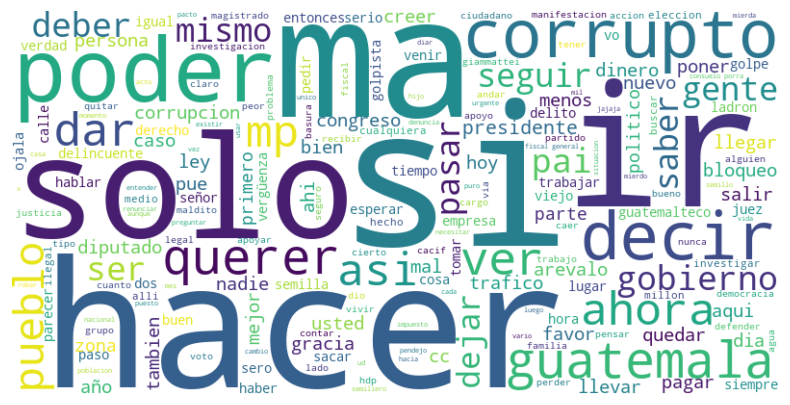

In [41]:
# Generar un WordCloud con las palabras más frecuentes en los tweets limpios
text = ' '.join(traficogt_df['tweet_limpio'].dropna().values)
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

La nube de palabras generada a partir de los tweets limpios destaca las palabras más frecuentes en las discusiones sobre el tráfico. Términos como **tráfico**, **carretera**, y **accidente** aparecen recurrentemente, reflejando los temas principales que afectan a los conductores en la ciudad. Sin embargo, palabras mas comunes como `ir`, `solo`, `hacer`, `si` son las que aparecen con un mayor tamaño. 
Cabe destacar que hay varias palabras relacionados al gobierno e instituciones publicas como `MP` (Ministerio Publico) o `CC` (Corte de Constitucionalidad), tambien esta destacada `corrupto`.

#### Análisis Detallado

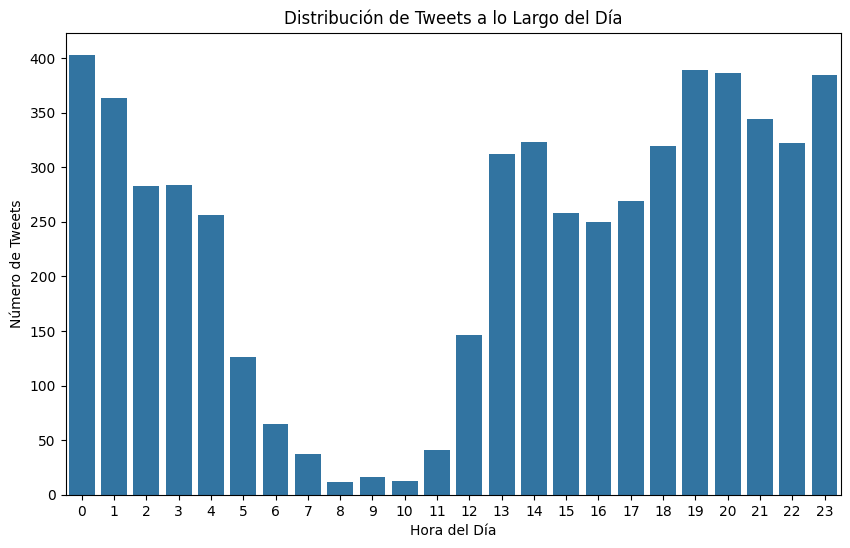

In [42]:
# 1. Distribución temporal de los tweets (agrupados por hora del día)
traficogt_df['hora'] = traficogt_df['fecha'].dt.hour

# Contar el número de tweets por hora
tweets_por_hora = traficogt_df.groupby('hora').size()

# Gráfico de barras para mostrar la distribución de tweets a lo largo del día
plt.figure(figsize=(10, 6))
sns.barplot(x=tweets_por_hora.index, y=tweets_por_hora.values)
plt.title('Distribución de Tweets a lo Largo del Día')
plt.xlabel('Hora del Día')
plt.ylabel('Número de Tweets')
plt.xticks(rotation=0)
plt.show()

El análisis de la distribución temporal de los tweets mostró que la actividad de los usuarios se concentra principalmente en ciertas horas del día. Los picos más altos de actividad coinciden con las horas pico de tráfico, lo que sugiere que los usuarios son más propensos a reportar problemas de tráfico durante esos momentos. Asimismo, hay horas del dia en las que se asume las personas ya se encuentran en casa y tienen el tiempo libre de hablar respecto al trafico, como a altas horas de la noche o en la madrugada.

In [43]:
# Usuarios mencionados en tweets con hashtags específicos (ignorando "no aplica")
tweets_con_menciones_y_hashtags = traficogt_df[(traficogt_df['usuarios_mencionados'] != 'no aplica') & (traficogt_df['hashtags'] != 'no aplica')]

# Crear una lista de pares (usuario, hashtag) para analizar la relación entre ambos
usuarios_hashtags = []
for idx, row in tweets_con_menciones_y_hashtags.iterrows():
    usuarios = row['usuarios_mencionados'].split(', ')
    hashtags = row['hashtags'].split(', ')
    for usuario in usuarios:
        for hashtag in hashtags:
            usuarios_hashtags.append((usuario.strip(), hashtag.strip()))

# Contar la frecuencia de menciones por usuario y hashtag
usuarios_hashtags_contador = Counter(usuarios_hashtags)

# Mostrar los usuarios más mencionados en tweets con hashtags específicos
print("Usuarios más mencionados en tweets con hashtags específicos:")
for (usuario, hashtag), frecuencia in usuarios_hashtags_contador.most_common(10):
    print(f"  - {usuario}: {frecuencia} menciones en tweets con el hashtag: {hashtag}")

Usuarios más mencionados en tweets con hashtags específicos:
  - traficogt: 20 menciones en tweets con el hashtag: guatemala
  - traficogt: 16 menciones en tweets con el hashtag: traficogt
  - amilcarmontejo: 7 menciones en tweets con el hashtag: guatemala
  - amilcarmontejo: 7 menciones en tweets con el hashtag: tráfico
  - traficogt: 7 menciones en tweets con el hashtag: tráfico
  - amilcarmontejo: 6 menciones en tweets con el hashtag: traficogt
  - traficogt: 6 menciones en tweets con el hashtag: transitogt
  - amilcarmontejo: 6 menciones en tweets con el hashtag: transmetro
  - traficogt: 6 menciones en tweets con el hashtag: transmetro
  - rquinonezl: 6 menciones en tweets con el hashtag: tráfico


Al analizar los usuarios más mencionados en tweets con hashtags específicos, se encontró que `@traficogt` y `@amilcarmontejo` son los usuarios más asociados a hashtags como **#guatemala**, **#trafico**, y **#transmetro**. Estos usuarios juegan un papel importante en las discusiones sobre el tráfico en la ciudad y su interacción con estos hashtags sugiere que son fuentes clave de información para otros usuarios en esos contextos.

In [44]:
# Filtrar los tweets que contienen una palabra clave
def filter_tweets_by_keyword(df, palabra_clave):
    tweets_con_palabra_clave = df[df['tweet_limpio'].str.contains(palabra_clave, case=False, na=False)]

    # Contar cuántas veces se menciona a los usuarios en estos tweets
    usuarios_mencionados_palabra_clave = []
    for idx, row in tweets_con_palabra_clave.iterrows():
        usuarios = row['usuarios_mencionados'].split(', ')
        for usuario in usuarios:
            usuarios_mencionados_palabra_clave.append(usuario.strip())

    # Contar la frecuencia de usuarios mencionados en tweets con la palabra clave
    usuarios_palabra_clave_contador = Counter(usuarios_mencionados_palabra_clave)

    # Mostrar los usuarios más mencionados en tweets con la palabra clave
    print(f"\nUsuarios más mencionados en tweets con la palabra clave '{palabra_clave}':")
    for usuario, frecuencia in usuarios_palabra_clave_contador.most_common(5):
        print(f"  - {usuario}: {frecuencia} menciones")

In [45]:
# Usuarios mencionados en tweets con palabras clave específicas
tweets_con_menciones_y_tweet_limpio = traficogt_df[(traficogt_df['usuarios_mencionados'] != 'no aplica') & (traficogt_df['tweet_limpio'] != '')]

filter_tweets_by_keyword(tweets_con_menciones_y_tweet_limpio, "lluvia")


Usuarios más mencionados en tweets con la palabra clave 'lluvia':
  - traficogt: 6 menciones
  - pmt_villanueva: 1 menciones
  - muniguate: 1 menciones
  - munimixco_: 1 menciones
  - ronald_mackay: 1 menciones


En relación con la palabra clave "**lluvia**", se identificó que `@traficogt` fue el usuario más mencionado, con 6 menciones, mientras que otras cuentas como `@pmt_villanueva`, `@muniguate`, y `@munimixco_` fueron mencionadas de manera esporádica. Esto indica que `@traficogt` sigue siendo la fuente principal de información, incluso cuando las discusiones giran en torno a problemas causados por la lluvia. Aunque la aparicion de las municipalidades y policia de transito indica que puede existir disgustos por el estado de las vias.

In [46]:
filter_tweets_by_keyword(tweets_con_menciones_y_tweet_limpio, "trafico")


Usuarios más mencionados en tweets con la palabra clave 'trafico':
  - traficogt: 121 menciones
  - amilcarmontejo: 42 menciones
  - muniguate: 18 menciones
  - pmtmuniguate: 12 menciones
  - rquinonezl: 11 menciones


En cuanto a la palabra clave "**tráfico**", los usuarios más mencionados fueron `@traficogt` con 119 menciones, seguido de `@amilcarmontejo` con 41 menciones. También destacan otras cuentas institucionales como `@muniguate` y `@pmtmuniguate`, que fueron mencionadas en un contexto relacionado con el manejo del tráfico, lo que refuerza la idea de que estas cuentas son vistas como autoridades o fuentes clave en temas de movilidad.

In [47]:
# tweets vacíos tras la limpieza
tweets_vacios = traficogt_df[traficogt_df['tweet_limpio'] == '']
num_tweets_vacios = len(tweets_vacios)
porcentaje_tweets_vacios = (num_tweets_vacios / len(traficogt_df)) * 100

print(f"\nNúmero de tweets vacíos tras la limpieza: {num_tweets_vacios}")
print(f"Porcentaje de tweets vacíos: {porcentaje_tweets_vacios:.2f}%")


Número de tweets vacíos tras la limpieza: 382
Porcentaje de tweets vacíos: 6.82%


Finalmente, el análisis de los tweets vacíos tras la limpieza reveló que un **6.82%** de los tweets quedaron sin contenido significativo, ya que estos consistían principalmente en menciones, emojis o caracteres especiales. Este porcentaje relativamente bajo sugiere que la mayoría de los tweets contenían información relevante relacionada con el tráfico, mientras que solo una pequeña fracción carecía de contenido textual.

#### Preguntas Interesantes

##### ¿Qué usuarios son los más mencionados en tweets relacionados con el tráfico y en qué medida influyen en las discusiones?

A partir del análisis de las menciones, se identificó que `@traficogt` es el usuario más mencionado, con **4241** menciones. Esto lo posiciona como una fuente clave de información y seguimiento de temas relacionados con el tráfico. Otros usuarios que influyen en las discusiones incluyen `@amilcarmontejo` con 166 menciones, y `@barevalodeleon` con 432 menciones. Estas cuentas, junto con `@drgiammattei` y `@prensacomunitar`, son mencionadas con frecuencia en temas de tráfico y, por lo tanto, juegan un papel importante en el intercambio de información entre usuarios de la plataforma.

##### ¿Cuáles son los hashtags más utilizados en relación con el tráfico en la ciudad y cómo se distribuyen entre los usuarios mencionados?

Los hashtags más comunes utilizados en los tweets relacionados con el tráfico son `#guatemala`, `#trafico`, `#ahora`, y `#transmetro`. Estos hashtags están mayormente asociados a menciones de usuarios clave como **@traficogt** y **@amilcarmontejo**. Por ejemplo, **@traficogt** fue mencionado 20 veces en tweets que contenían el hashtag `#guatemala` y 16 veces con el hashtag `#traficogt`, mientras que **@amilcarmontejo** fue mencionado en múltiples ocasiones en tweets con los hashtags `#trafico` y `#transmetro`. Esto indica que estos usuarios son particularmente activos en temas relacionados con la movilidad en la ciudad y que sus publicaciones están vinculadas con la difusión de información sobre el tráfico.

##### ¿Qué relación existe entre los tweets con menciones y las palabras clave específicas como 'tráfico' y 'lluvia'?

En los tweets que contienen la palabra "tráfico", **@traficogt** es el usuario más mencionado, con 119 menciones, seguido de **@amilcarmontejo** con 41 menciones. Esto sugiere que ambos usuarios son vistos como referencias importantes en temas de congestión vehicular. Por otro lado, en los tweets que contienen la palabra "`lluvia`", **@traficogt** vuelve a ser el más mencionado con 6 menciones, seguido de algunas cuentas institucionales como **@pmt_villanueva** y **@muniguate** con menciones esporádicas. Esto evidencia que **@traficogt** es el principal referente tanto en temas de tráfico como en problemas relacionados con la lluvia, consolidando su rol como una fuente clave de información en estas situaciones.

## Análisis de la topología de la red

In [71]:
# Crear un grafo dirigido
G = nx.DiGraph()

# 1. Obtener los usuarios únicos de la columna 'usuario'
usuarios = set(traficogt_df['usuario'].unique())  # Todos los usuarios únicos que publican tweets

# Agregar los usuarios como nodos al grafo
G.add_nodes_from(usuarios)

# 2. Crear aristas para menciones y respuestas
for idx, row in traficogt_df.iterrows():
    usuario_origen = row['usuario']

    # Agregar aristas para menciones, solo si los mencionados están en 'usuario' o los agregamos si no están
    if row['usuarios_mencionados'] != 'no aplica':
        usuarios_mencionados = row['usuarios_mencionados'].split(', ')
        for usuario_mencionado in usuarios_mencionados:
            if usuario_mencionado.strip() not in usuarios:
                G.add_node(usuario_mencionado.strip())  # Agregar al grafo si no está
            G.add_edge(usuario_origen, usuario_mencionado.strip(), label="mencionó")

    # Agregar aristas para respuestas, solo si el usuario al que se responde está en 'usuario' o lo agregamos
    if row['respuesta_a_usuario'] != 'no aplica' and row['respuesta_a_usuario'] not in usuarios:
        G.add_node(row['respuesta_a_usuario'])  # Agregar al grafo si no está
        G.add_edge(usuario_origen, row['respuesta_a_usuario'], label="respondió")

# Hasta este punto tenemos un grafo completo con nodos de usuarios y aristas para menciones o respuestas.

# 3. Crear la muestra conectada
# Obtener los nodos más conectados (entrantes + salientes)
nodos_con_aristas = [n for n in G.nodes() if G.degree(n) > 0]
nodos_ordenados = sorted(nodos_con_aristas, key=lambda x: G.degree(x), reverse=True)

# Crear una subred asegurando que los nodos tengan al menos una conexión entre ellos
conexiones = []
for nodo in nodos_ordenados:
    vecinos = list(G.neighbors(nodo))  # Obtener los vecinos conectados
    if vecinos and any(vecino in nodos_ordenados for vecino in vecinos):
        conexiones.append(nodo)
    if len(conexiones) >= 25:  # Limitar la muestra a 25 nodos conectados
        break

# Crear la subred con los nodos seleccionados
subgrafo_muestra = G.subgraph(conexiones)

In [72]:
# 4. Visualización interactiva de la subred de 25 nodos
mini_net = Network(notebook=False, directed=True)
mini_net.from_nx(subgrafo_muestra)

# Guardar la visualización de la muestra en un archivo HTML
mini_net.save_graph("output/red_tweets_muestra.html")

# También guardamos el grafo completo para análisis posterior
net = Network(notebook=False, directed=True)
net.from_nx(G)
net.save_graph("output/red_tweets_completa.html")

Para visualizar la red interactiva, prueba abriendo el archivo html `red_tweets_completa.html` en su navegador. Si no se llegase a cargar prueba con el grafo muestra `red_tweets_muestra.hmlt`.

A continuacion el grafo muestra:
<br>
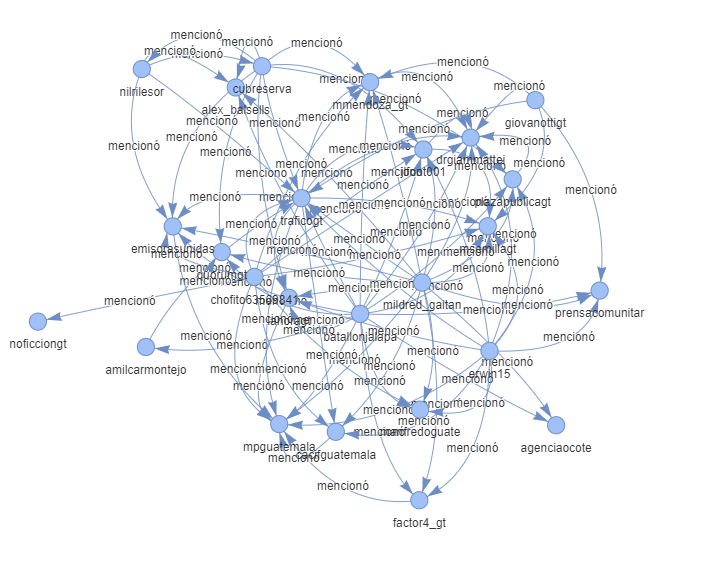
<br>

Nota: Debido a la alta dimensionalidad del grafo completo, no es posible desplegarlo dentro del jupyter notebook sin generar problemas con el equipo. Incluso abriendo el archivo desde el navegador es tardado. 
Por lo que se deja una imagen si se desea evitar el tener que cargar la red completa:
<br>
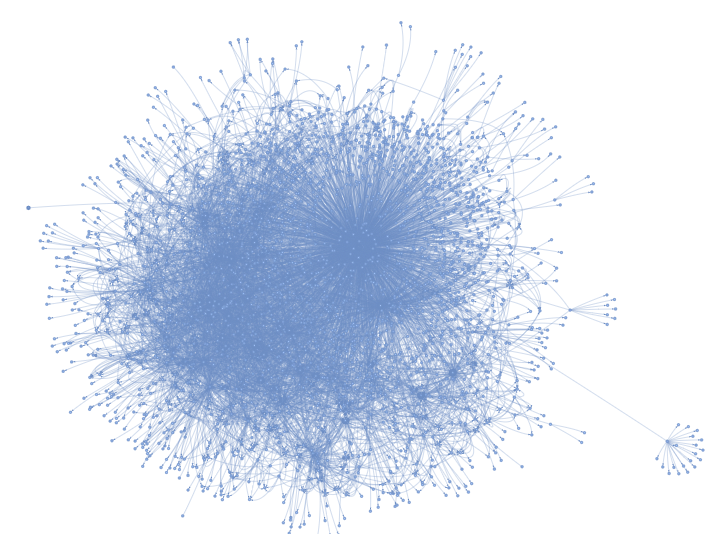
<br>
En esta imagen se aprecia que hay una gran cantidad de nodos, pero no tiene interconexiones todos con todos, la mayoria son nodos que estan dirigidos a nodos en especificos. Tambien podemos ver un claro ejemplo de un subgrupo donde hay un nodo interconectado a varios, pero este solo tiene una conexion a un nodo al gran cumulo de nodos.


In [76]:
# Calcular las métricas de red
densidad = nx.density(G)

# Si la red es conexa calcular el diámetro
if nx.is_strongly_connected(G):
    diametro = nx.diameter(G)
else:
    componentes = list(nx.strongly_connected_components(G))
    diametro = max([nx.diameter(G.subgraph(c).copy()) for c in componentes])

coeficiente_agrupamiento = nx.average_clustering(G)

# Resultados
print(f"Densidad de la red: {densidad}")
print(f"Diámetro de la red: {diametro}")
print(f"Coeficiente de agrupamiento: {coeficiente_agrupamiento}")


Densidad de la red: 0.0009752691084240098
Diámetro de la red: 4
Coeficiente de agrupamiento: 0.11851137630738766


- **Densidad**: La red presenta un coeficienta muy bajo de densidad, es decir que la red de interacciones entre usuarios tiene conexiones aisladas en pequeños grupos, pues para una red de mas de 2000 usuarios el maximo posible de conexiones la cantidad de interconexiones entre nodos es muy pequeña a comparacion del maximo posible.
  
- **Diámetro**: Dado que la red está bastante dispersa, el diámetro es relativamente pequeño (4), lo que indica que aún es posible conectar diferentes partes de la red en pocos pasos. Esto debido principalmente a que no existe forma de ir de un nodo de un extremo al otro, pues no existen conexiones, sin embargo en los subgrupos de la red (subredes) el mas grande de ellos requiere 4 pasos para llegar de un sub-extremo al otro.
  

- **Coeficiente de agrupamiento**: este valor muestra que hay una pequeña tendencia a formar grupos o clústeres, pero no es una red altamente agrupada. Reafirmando nuevamente que la red es poco conexa y los usuarios no interactuan con todos, pero si con algunos.

Estos valores sugieren que la red está compuesta por muchos usuarios que interactúan ocasionalmente entre si, pero también existen usuarios clave que actúan como conectores entre diferentes partes de la red. Estos usuarios permiten que la información o las interacciones fluyan rápidamente entre nodos, incluso en una red dispersa.